In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eotdl

eotdl.__version__

'2024.10.07'

In this notebook we generate the dataset for the use case

1. Generate list of Satellogic images to be used (containing bb and acquisition time)
2. Explore available S1/S2 images with different criteria
	- bounding box overlap
	- acquisition time overlap
3. Download matching S1/S2 at given resolution
4. Generate metadata and ingest to EOTDL 

In [3]:
import geopandas as gpd

# gdf = gpd.read_parquet('/fastdata/Satellogic/data/satellogic-earthview-items.parquet')
gdf = gpd.read_parquet('/fastdata/Satellogic/data/satellogic-earthview-items-with-matches.parquet')

gdf.head()

,json_path,zone,region,date,geometry,matches
0,data/json/zone=51S/region=357067_6579845/date=...,51S,357067_6579845,2022-10-26,"POLYGON ((121.50829 -30.90962, 121.50835 -30.9...",[{'id': 'S2B_MSIL2A_20221027T015619_N0400_R117...
1,data/json/zone=46N/region=374867_2457086/date=...,46N,374867_2457086,2022-12-25,"POLYGON ((91.78970 22.21120, 91.78967 22.21467...",[{'id': 'S2B_MSIL2A_20221227T043209_N0509_R133...
2,data/json/zone=38N/region=601805_4299370/date=...,38N,601805_4299370,2022-10-05,"POLYGON ((46.17736 38.83375, 46.17741 38.83721...",[{'id': 'S2B_MSIL2A_20221008T074809_N0400_R135...
3,data/json/zone=20S/region=598796_7170926/date=...,20S,598796_7170926,2022-09-03,"POLYGON ((-62.01249 -25.57924, -62.01252 -25.5...",[{'id': 'S2B_MSIL2A_20220906T140709_N0400_R110...
4,data/json/zone=50N/region=698978_4416263/date=...,50N,698978_4416263,2022-09-04,"POLYGON ((119.33101 39.86955, 119.33112 39.873...",[{'id': 'S2A_MSIL2A_20220906T025541_N0400_R032...


In [4]:
gdf.shape

(1000000, 6)

In [5]:
gdf['num_matches'] = gdf.matches.apply(len)
gdf['num_matches'].value_counts()

num_matches
2     342069
1     284880
3     168153
4     104093
6      75391
8       7456
0       4926
12      4115
9       3116
5       2010
11      1322
10      1273
7        963
15       233
Name: count, dtype: int64

In [48]:
gdf['matches'].sample(1).values

array([array([{'id': 'S2B_MSIL2A_20221129T101259_N0400_R022_T31PCQ_20221129T123658', 'properties': {'datetime': '2022-11-29T10:27:24Z', 'eo:cloud_cover': 0.0}},
              {'id': 'S2B_MSIL2A_20221129T101259_N0400_R022_T31PDQ_20221129T123658', 'properties': {'datetime': '2022-11-29T10:27:21Z', 'eo:cloud_cover': 0.0}},
              {'id': 'S2A_MSIL2A_20221124T101341_N0400_R022_T31PCQ_20221124T153211', 'properties': {'datetime': '2022-11-24T10:27:25Z', 'eo:cloud_cover': 0.0}},
              {'id': 'S2A_MSIL2A_20221124T101341_N0400_R022_T31PDQ_20221124T153211', 'properties': {'datetime': '2022-11-24T10:27:22Z', 'eo:cloud_cover': 0.0}}],
             dtype=object)                                                                                                                                       ],
      dtype=object)

In [167]:
from datetime import datetime
import json
from pathlib import Path
import requests
from eotdl.tools import bbox_from_centroid
from eotdl.access import download_sentinel_imagery
import shutil
import os

sample =  gdf.sample(1)

results = sample.matches.values
CLOUD_COVER_THRESHOLD = 0.1
WIDTH = 38
HEIGHT = 38

shutil.rmtree('sample')
os.makedirs('sample', exist_ok=True)

if len(results[0]) > 0:
	# filter by cloud cover
	results_filtered = [r for r in results[0] if r['properties']['eo:cloud_cover'] <= CLOUD_COVER_THRESHOLD]
	if len(results_filtered) > 0:
		# Find closest match by date
		date = sample.date.iloc[0]
		closest_match = min(results_filtered, key=lambda x: abs(datetime.fromisoformat(x['properties']['datetime'].replace('Z','')) - date))
		# satellogic
		json_path = sample.json_path.iloc[0]
		json_path = json_path.replace('data/', '/fastdata/Satellogic/data/')
		with open(json_path, 'r') as f:
			metadata = json.load(f)
		url = metadata['assets']['analytic']['href']
		output_path = Path("sample/satellogic") / url.split('/')[-1]
		output_path.parent.mkdir(parents=True, exist_ok=True)
		response = requests.get(url, stream=True)
		response.raise_for_status()
		with open(output_path, 'wb') as f:
			for chunk in response.iter_content(chunk_size=8192):
				f.write(chunk)
		# sentinel
		name = json_path.split('/')[-1].replace('_metadata.json', '_S2L2A')
		dst_path_sentinel = "sample/sentinel2/" + name + '.tif'
		centroid = sample.geometry.iloc[0].centroid
		custom_bbox = bbox_from_centroid(x=centroid.y, y=centroid.x, pixel_size=10, width=WIDTH, height=HEIGHT)
		# print(sample.geometry.iloc[0].bounds)
		print(custom_bbox, closest_match['properties']['datetime'].split('T')[0])
		download_sentinel_imagery("sample/sentinel2", closest_match['properties']['datetime'], custom_bbox, "sentinel-2-l2a", name=name)
		# Path(str(dst_path_sentinel).replace('.tif', '.json')).unlink(missing_ok=True)

[54.34840178692108, 22.42434785520395, 54.35202525381773, 22.427837669131325] 2022-11-09
buenas
hola
/tmp/sentinelhub/ee41259a-a262-4f7c-b373-8dafba1004bb/3b579a5a2b2c7048c5142504f9626b9f/response.tiff


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


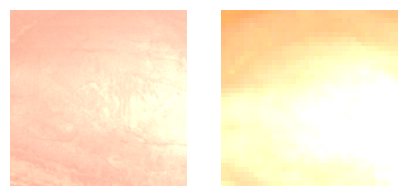

In [168]:
import matplotlib.pyplot as plt
import rasterio as rio

fig, axs = plt.subplots(1, 2, figsize=(5, 3))
axs[0].imshow((rio.open(output_path).read()[:3,...].transpose(1, 2, 0) / 3000).clip(0, 1))
axs[0].axis('off')
axs[1].imshow((rio.open(dst_path_sentinel).read()[(3,2,1),...].transpose(1, 2, 0) / 3000).clip(0, 1))
axs[1].axis('off')
plt.show()

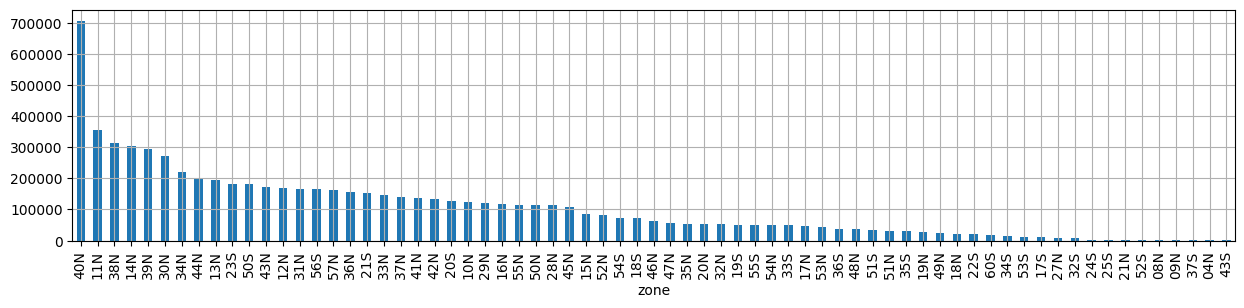

In [79]:
import matplotlib.pyplot as plt

# plot histogram with number of images per zone
fig = plt.figure(figsize=(15, 3))
gdf['zone'].value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [80]:
len(gdf['zone'].unique()), len(gdf['region'].unique())

(69, 2967002)

In [81]:
gdf['zone'].value_counts().min()

np.int64(1126)

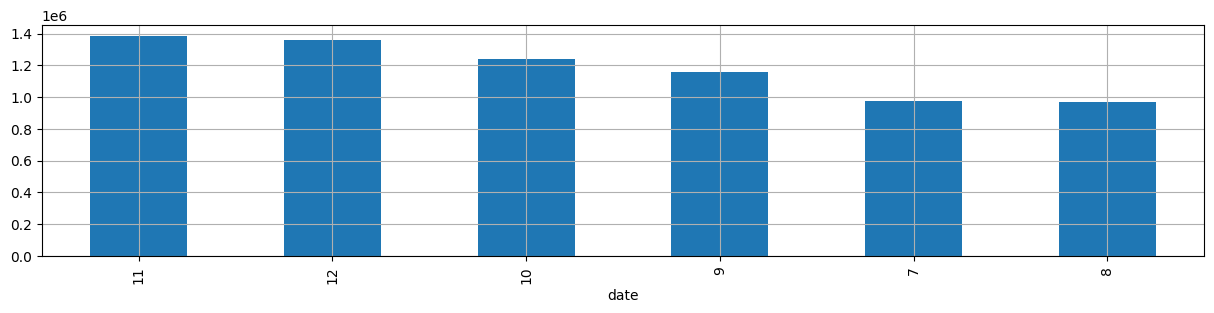

In [82]:
# plot histogram with number of images per month (all images are from 2022)
fig = plt.figure(figsize=(15, 3))
gdf['date'].dt.month.value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [83]:
zones = sorted(gdf['zone'].unique())
zone_gdf = gdf[gdf['zone'] == zones[4]]
sample = zone_gdf.sample(5, random_state=2025)
sample

,json_path,zone,region,date,geometry
329527,data/json/zone=11N/region=388859_3755090/date=...,11N,388859_3755090,2022-08-24,"POLYGON ((-118.19829 33.92698, -118.19834 33.9..."
264252,data/json/zone=11N/region=385653_3724647/date=...,11N,385653_3724647,2022-09-01,"POLYGON ((-118.22904 33.65213, -118.22909 33.6..."
167333,data/json/zone=11N/region=326512_4182856/date=...,11N,326512_4182856,2022-10-11,"POLYGON ((-118.96550 37.77321, -118.96559 37.7..."
222623,data/json/zone=11N/region=382965_3730407/date=...,11N,382965_3730407,2022-08-23,"POLYGON ((-118.25878 33.70377, -118.25883 33.7..."
368677,data/json/zone=11N/region=392315_3730514/date=...,11N,392315_3730514,2022-10-05,"POLYGON ((-118.15791 33.70573, -118.15796 33.7..."


Download the images

In [86]:
!rm -rf /fastdata/Satellogic/data/tifs/satellogic/*
!rm -rf /fastdata/Satellogic/data/tifs/sentinel2/*

In [88]:
from dataset import search_matches

matches = []
for _, item in sample.iterrows():
	print(item.json_path)
	paths = search_matches((item.date, item.geometry.bounds, item.json_path, item.geometry.centroid))
	matches.append(paths)

data/json/zone=11N/region=388859_3755090/date=2022-08-24/20220824_191309_SN24_11N_388859_3755090_metadata.json
data/json/zone=11N/region=385653_3724647/date=2022-09-01/20220901_182403_SN15_11N_385653_3724647_metadata.json
data/json/zone=11N/region=326512_4182856/date=2022-10-11/20221011_213507_SN28_11N_326512_4182856_metadata.json
data/json/zone=11N/region=382965_3730407/date=2022-08-23/20220823_222648_SN20_11N_382965_3730407_metadata.json
data/json/zone=11N/region=392315_3730514/date=2022-10-05/20221005_222819_SN22_11N_392315_3730514_metadata.json


In [89]:
matches

[None,
 ('/fastdata/Satellogic/data//tifs/sentinel2/20220901_182403_SN15_11N_385653_3724647_S2L2A.tif',
  PosixPath('/fastdata/Satellogic/data/tifs/satellogic/20220901_182403_SN15_11N_385653_3724647_TOA.tif')),
 ('/fastdata/Satellogic/data//tifs/sentinel2/20221011_213507_SN28_11N_326512_4182856_S2L2A.tif',
  PosixPath('/fastdata/Satellogic/data/tifs/satellogic/20221011_213507_SN28_11N_326512_4182856_TOA.tif')),
 None,
 None]

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


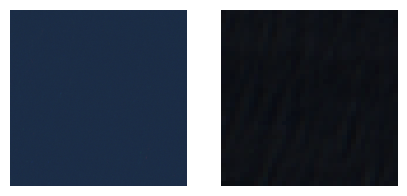

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


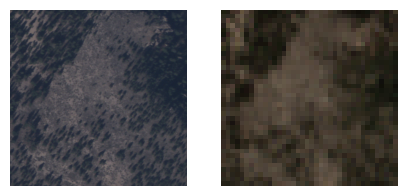

In [90]:
import rasterio as rio

for match in matches:
	if match is None: continue
	s2_image, sat_image = match
	fig, axs = plt.subplots(1, 2, figsize=(5, 3))
	axs[0].imshow((rio.open(sat_image).read()[:3,...].transpose(1, 2, 0) / 4000).clip(0, 1))
	axs[0].axis('off')
	axs[1].imshow((rio.open(s2_image).read()[(3,2,1),...].transpose(1, 2, 0) / 4000).clip(0, 1))
	axs[1].axis('off')
	plt.show()

